In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from slsim.image_simulation import (
    image_data_class,
    lens_image,
    rgb_image_from_image_list,
)

## Validation of image simulation in SLSim

Most of the functions in the image simulation take Lens class as an input. So, we need to

supply all the dc2 galaxy information in the form of Lens class. So, here we mimic Lens 

class only with necessary Lens class parts which are necessary for image simulation.

Before runing this notebook, please download all the data needed from the following link:

https://github.com/LSST-strong-lensing/data_public/tree/main/dp0_images_data_for_slsim_image_validation

Then, please change data path to your storage path.

In [2]:
## lens_class for validation
class Lens1(object):
    def __init__(
        self, kwargs_model, kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps
    ):
        self.kwargs_model = kwargs_model
        self.kwargs_lens = kwargs_lens
        self.kwargs_source = kwargs_source
        self.kwargs_lens_light = kwargs_lens_light
        self.kwargs_ps = kwargs_ps

    def lenstronomy_kwargs(self, band=None):
        self.band = band
        kwargs_params = {
            "kwargs_lens": self.kwargs_lens,
            "kwargs_source": self.kwargs_source,
            "kwargs_lens_light": self.kwargs_lens_light,
            "kwargs_ps": self.kwargs_ps,
        }
        return self.kwargs_model, kwargs_params


class Lens2(object):
    def __init__(self, kwargs_model):
        self.kwargs_model = kwargs_model

    def lenstronomy_kwargs(self, band=None):
        return self.kwargs_model, None

## Let's get dc2 galaxy center in slsim image grid

In [3]:
kwargs_model = {
    "lens_light_model_list": ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"],
    "lens_model_list": ["EPL", "SHEAR", "CONVERGENCE"],
    "source_light_model_list": ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"],
}

In [4]:
kwarg_model = Lens2(kwargs_model)

In [5]:
data_class = image_data_class(
    kwarg_model,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=35,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)

In [6]:
galaxy_center_pix_x_1 = 17.43411518
galaxy_center_pix_y_1 = 16.92526535
galaxy_center_pix_x_2 = 16.84335831
galaxy_center_pix_y_2 = 16.52869664
center_cood_x_1, center_coord_y_1 = data_class.map_pix2coord(
    galaxy_center_pix_x_1, galaxy_center_pix_y_1
)
center_cood_x_2, center_coord_y_2 = data_class.map_pix2coord(
    galaxy_center_pix_x_2, galaxy_center_pix_y_2
)

## Load dc2 galaxies

In [7]:
with open(
    "/Users/narayankhadka/downloads/galaxy_sample_dc2_new_all_angle.txt", "rb"
) as file:
    # Use pickle.load() to load the data from the file
    dc2_galaxies = pickle.load(file)

In [8]:
dc2_galaxies = Table(dc2_galaxies)

In [9]:
dc2_galaxies[2]["ra"], dc2_galaxies[2]["dec"]

(61.99284796403353, -36.9900209621661)

In [10]:
#Position angle in slsim is defined from east to north. While in DP0, it is defined from
#north to east. So, we convert DP0 position angle to slsim convension by substracting
#DP0 angle from 90.
rotation_angle_1 = np.pi * (90-dc2_galaxies[2]["position_angle_true_dc2"]) / 180
rotation_angle_2 = np.pi * (90-dc2_galaxies[7]["position_angle_true_dc2"]) / 180

In [11]:
## axis ratios of disk dominated galaxy
q_disk_1 = dc2_galaxies[2]["size_minor_disk_true"] / dc2_galaxies[2]["size_disk_true"]
q_bulge_1 = (
    dc2_galaxies[2]["size_minor_bulge_true"] / dc2_galaxies[2]["size_bulge_true"]
)
q_1 = dc2_galaxies[2]["size_minor_true"] / dc2_galaxies[2]["size_true"]

## axis ratios of bulge dominated galaxy
q_disk_2 = dc2_galaxies[7]["size_minor_disk_true"] / dc2_galaxies[7]["size_disk_true"]
q_bulge_2 = (
    dc2_galaxies[7]["size_minor_bulge_true"] / dc2_galaxies[7]["size_bulge_true"]
)
q_2 = dc2_galaxies[7]["size_minor_true"] / dc2_galaxies[7]["size_true"]

In [12]:
## Disk dominated galaxy
epsilon_disk_1 = (1 - q_disk_1) / (1 + q_disk_1)
epsilon_bulge_1 = (1 - q_bulge_1) / (1 + q_bulge_1)
epsilon_1 = (1 - q_1) / (1 + q_1)

## Bulge dominated galaxy
epsilon_disk_2 = (1 - q_disk_2) / (1 + q_disk_2)
epsilon_bulge_2 = (1 - q_bulge_2) / (1 + q_bulge_2)
epsilon_2 = (1 - q_2) / (1 + q_2)

In [13]:
## disk dominated
e1_disk_1 = epsilon_disk_1 * np.cos(2 * rotation_angle_1)
e2_disk_1 = epsilon_disk_1 * np.sin(2 * rotation_angle_1)
e1_bulge_1 = epsilon_bulge_1 * np.cos(2 * rotation_angle_1)
e2_bulge_1 = epsilon_bulge_1 * np.sin(2 * rotation_angle_1)
e1_1 = epsilon_1 * np.cos(2 * rotation_angle_1)
e2_1 = epsilon_1 * np.sin(2 * rotation_angle_1)

## Bulge dominated
e1_disk_2 = epsilon_disk_2 * np.cos(2 * rotation_angle_2)
e2_disk_2 = epsilon_disk_2 * np.sin(2 * rotation_angle_2)
e1_bulge_2 = epsilon_bulge_2 * np.cos(2 * rotation_angle_2)
e2_bulge_2 = epsilon_bulge_2 * np.sin(2 * rotation_angle_2)
e1_2 = epsilon_2 * np.cos(2 * rotation_angle_2)
e2_2 = epsilon_2 * np.sin(2 * rotation_angle_2)

In [14]:
dc2_galaxies[7]["ra"], dc2_galaxies[7]["dec"]

(62.00273461841879, -37.00827463174009)

## Prepare lenstronomy kwargs from a dc2 galaxy
We select galaxies centered at (ra, dec) =  (62.00273461841879, -37.00827463174009) 

and (61.99284796403353, -36.9900209621661) degree. One can find image of this galaxy in DP0 

data. We download image of this galaxy from DP0 and compare it with image of the same galaxy 

silulated using slsim.

In [15]:
## lenstronomy kwargs for disk dominated galaxy
kwargs_lens_1 = [
    {
        "theta_E": 1,
        "gamma": 2,
        "e1": e1_1,
        "e2": e2_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
    {
        "gamma1": dc2_galaxies[2]["shear_1"],
        "gamma2": dc2_galaxies[2]["shear_2"],
        "ra_0": 0,
        "dec_0": 0,
    },
    {"kappa": dc2_galaxies[2]["convergence"], "ra_0": 0, "dec_0": 0},
]
kwargs_source_1 = None
flux_i_1 = 10 ** (-dc2_galaxies[2]["mag_true_i_lsst"] / 2.5)
mag_bulge_i_1 = -2.5 * np.log10(dc2_galaxies[2]["bulge_to_total_ratio_i"] * flux_i_1)
mag_disk_i_1 = -2.5 * np.log10(
    (1 - dc2_galaxies[2]["bulge_to_total_ratio_i"]) * flux_i_1
)
kwargs_lens_light_i_1 = [
    {
        "magnitude": mag_bulge_i_1,
        "R_sersic": dc2_galaxies[2]["size_bulge_true"],
        "n_sersic": 4.0,
        "e1": e1_bulge_1,
        "e2": e2_bulge_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
    {
        "magnitude": mag_disk_i_1,
        "R_sersic": dc2_galaxies[2]["size_disk_true"],
        "n_sersic": 1.0,
        "e1": e1_disk_1,
        "e2": e2_disk_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
]
flux_r_1 = 10 ** (-dc2_galaxies[2]["mag_true_r_lsst"] / 2.5)
mag_bulge_r_1 = -2.5 * np.log10(dc2_galaxies[2]["bulge_to_total_ratio_i"] * flux_r_1)
mag_disk_r_1 = -2.5 * np.log10(
    (1 - dc2_galaxies[2]["bulge_to_total_ratio_i"]) * flux_r_1
)
kwargs_lens_light_r_1 = [
    {
        "magnitude": mag_bulge_r_1,
        "R_sersic": dc2_galaxies[2]["size_bulge_true"],
        "n_sersic": 4.0,
        "e1": e1_bulge_1,
        "e2": e2_bulge_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
    {
        "magnitude": mag_disk_r_1,
        "R_sersic": dc2_galaxies[2]["size_disk_true"],
        "n_sersic": 1.0,
        "e1": e1_disk_1,
        "e2": e2_disk_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
]
flux_g_1 = 10 ** (-dc2_galaxies[2]["mag_true_g_lsst"] / 2.5)
mag_bulge_g_1 = -2.5 * np.log10(dc2_galaxies[2]["bulge_to_total_ratio_i"] * flux_g_1)
mag_disk_g_1 = -2.5 * np.log10(
    (1 - dc2_galaxies[2]["bulge_to_total_ratio_i"]) * flux_g_1
)
kwargs_lens_light_g_1 = [
    {
        "magnitude": mag_bulge_g_1,
        "R_sersic": dc2_galaxies[2]["size_bulge_true"],
        "n_sersic": 4.0,
        "e1": e1_bulge_1,
        "e2": e2_bulge_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
    {
        "magnitude": mag_disk_g_1,
        "R_sersic": dc2_galaxies[2]["size_disk_true"],
        "n_sersic": 1.0,
        "e1": e1_disk_1,
        "e2": e2_disk_1,
        "center_x": center_cood_x_1,
        "center_y": center_coord_y_1,
    },
]
kwargs_ps_1 = None

In [16]:
## lenstronomy kwargs for bulge dominated galaxy
kwargs_lens_2 = [
    {
        "theta_E": 1,
        "gamma": 2,
        "e1": e1_2,
        "e2": e2_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
    {
        "gamma1": dc2_galaxies[7]["shear_1"],
        "gamma2": dc2_galaxies[7]["shear_2"],
        "ra_0": 0,
        "dec_0": 0,
    },
    {"kappa": dc2_galaxies[7]["convergence"], "ra_0": 0, "dec_0": 0},
]
kwargs_source_2 = None
flux_i_2 = 10 ** (-dc2_galaxies[7]["mag_true_i_lsst"] / 2.5)
mag_bulge_i_2 = -2.5 * np.log10(dc2_galaxies[7]["bulge_to_total_ratio_i"] * flux_i_2)
mag_disk_i_2 = -2.5 * np.log10(
    (1 - dc2_galaxies[7]["bulge_to_total_ratio_i"]) * flux_i_2
)
kwargs_lens_light_i_2 = [
    {
        "magnitude": mag_bulge_i_2,
        "R_sersic": dc2_galaxies[7]["size_bulge_true"],
        "n_sersic": 4.0,
        "e1": e1_bulge_2,
        "e2": e2_bulge_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
    {
        "magnitude": mag_disk_i_2,
        "R_sersic": dc2_galaxies[7]["size_disk_true"],
        "n_sersic": 1.0,
        "e1": e1_disk_2,
        "e2": e2_disk_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
]
flux_r_2 = 10 ** (-dc2_galaxies[7]["mag_true_r_lsst"] / 2.5)
mag_bulge_r_2 = -2.5 * np.log10(dc2_galaxies[7]["bulge_to_total_ratio_i"] * flux_r_2)
mag_disk_r_2 = -2.5 * np.log10(
    (1 - dc2_galaxies[7]["bulge_to_total_ratio_i"]) * flux_r_2
)
kwargs_lens_light_r_2 = [
    {
        "magnitude": mag_bulge_r_2,
        "R_sersic": dc2_galaxies[7]["size_bulge_true"],
        "n_sersic": 4.0,
        "e1": e1_bulge_2,
        "e2": e2_bulge_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
    {
        "magnitude": mag_disk_r_2,
        "R_sersic": dc2_galaxies[7]["size_disk_true"],
        "n_sersic": 1.0,
        "e1": e1_disk_2,
        "e2": e2_disk_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
]
flux_g_2 = 10 ** (-dc2_galaxies[7]["mag_true_g_lsst"] / 2.5)
mag_bulge_g_2 = -2.5 * np.log10(dc2_galaxies[7]["bulge_to_total_ratio_i"] * flux_g_2)
mag_disk_g_2 = -2.5 * np.log10(
    (1 - dc2_galaxies[7]["bulge_to_total_ratio_i"]) * flux_g_2
)
kwargs_lens_light_g_2 = [
    {
        "magnitude": mag_bulge_g_2,
        "R_sersic": dc2_galaxies[7]["size_bulge_true"],
        "n_sersic": 4.0,
        "e1": e1_bulge_2,
        "e2": e2_bulge_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
    {
        "magnitude": mag_disk_g_2,
        "R_sersic": dc2_galaxies[7]["size_disk_true"],
        "n_sersic": 1.0,
        "e1": e1_disk_2,
        "e2": e2_disk_2,
        "center_x": center_cood_x_2,
        "center_y": center_coord_y_2,
    },
]
kwargs_ps_2 = None

## Initiate Lens class for each band

In [17]:
## disk dominated galaxy
lens_class_i_1 = Lens1(
    kwargs_model, kwargs_lens_1, kwargs_source_1, kwargs_lens_light_i_1, kwargs_ps_1
)
lens_class_r_1 = Lens1(
    kwargs_model, kwargs_lens_1, kwargs_source_1, kwargs_lens_light_r_1, kwargs_ps_1
)
lens_class_g_1 = Lens1(
    kwargs_model, kwargs_lens_1, kwargs_source_1, kwargs_lens_light_g_1, kwargs_ps_1
)

## Bulge dominated galaxy
lens_class_i_2 = Lens1(
    kwargs_model, kwargs_lens_2, kwargs_source_2, kwargs_lens_light_i_2, kwargs_ps_2
)
lens_class_r_2 = Lens1(
    kwargs_model, kwargs_lens_2, kwargs_source_2, kwargs_lens_light_r_2, kwargs_ps_2
)
lens_class_g_2 = Lens1(
    kwargs_model, kwargs_lens_2, kwargs_source_2, kwargs_lens_light_g_2, kwargs_ps_2
)

## Load psf and variance map for a dc2 galaxy

In [18]:
## disk dominated galaxy
psf_kernel_i_1 = np.load("/Users/narayankhadka/downloads/dc2_galaxy_2_kernel_i.npy")
psf_kernel_r_1 = np.load("/Users/narayankhadka/downloads/dc2_galaxy_2_kernel_r.npy")
psf_kernel_g_1 = np.load("/Users/narayankhadka/downloads/dc2_galaxy_2_kernel_g.npy")

## Bulge dominated galaxy
psf_kernel_i_2 = np.load("/Users/narayankhadka/downloads/dc2_galaxy_kernel_i.npy")
psf_kernel_r_2 = np.load("/Users/narayankhadka/downloads/dc2_galaxy_kernel_r.npy")
psf_kernel_g_2 = np.load("/Users/narayankhadka/downloads/dc2_galaxy_kernel_g.npy")

In [19]:
## disk dominated galaxy
dc2_galaxy_variance_i_1 = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_2_variance_i.npy")
)
dc2_galaxy_variance_g_1 = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_2_variance_g.npy")
)
dc2_galaxy_variance_r_1 = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_2_variance_r.npy")
)

## Bulge dominated galaxy
dc2_galaxy_variance_i_2 = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_variance_i.npy")
)
dc2_galaxy_variance_g_2 = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_variance_g.npy")
)
dc2_galaxy_variance_r_2 = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_variance_r.npy")
)

## Simulate image of a dc2 galaxy using slsim

In [20]:
## disk dominated galaxy images
dc2_galaxy_image_from_slsim_i_1 = lens_image(
    lens_class_i_1,
    band="i",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_i_1,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_i_1,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_g_1 = lens_image(
    lens_class_g_1,
    band="g",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_g_1,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_g_1,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_r_1 = lens_image(
    lens_class_r_1,
    band="r",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_r_1,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_r_1,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)

/Users/narayankhadka/lenstronomy/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/Users/narayankhadka/lenstronomy/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


In [21]:
## Bulge dominated galaxy images
dc2_galaxy_image_from_slsim_i_2 = lens_image(
    lens_class_i_2,
    band="i",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_i_2,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_i_2,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_g_2 = lens_image(
    lens_class_g_2,
    band="g",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_g_2,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_g_2,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_r_2 = lens_image(
    lens_class_r_2,
    band="r",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_r_2,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_r_2,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)

## Load dc2 galaxy image from DP0

In [22]:
## disk dominated galaxy
dc2_galaxy_image_from_dp0_i_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_2_i.npy"
)
dc2_galaxy_image_from_dp0_r_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_2_r.npy"
)
dc2_galaxy_image_from_dp0_g_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_2_g.npy"
)

## Bulge dominated galaxy
dc2_galaxy_image_from_dp0_i_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_i.npy"
)
dc2_galaxy_image_from_dp0_r_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_r.npy"
)
dc2_galaxy_image_from_dp0_g_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_g.npy"
)

## Compute the difference between slsim and DP0 
## images of the same galaxy

In [23]:
##disk dominated galaxy
diff_i_1 = dc2_galaxy_image_from_slsim_i_1 - dc2_galaxy_image_from_dp0_i_1
diff_r_1 = dc2_galaxy_image_from_slsim_r_1 - dc2_galaxy_image_from_dp0_r_1
diff_g_1 = dc2_galaxy_image_from_slsim_g_1 - dc2_galaxy_image_from_dp0_g_1

##Bulge dominated galaxy
diff_i_2 = dc2_galaxy_image_from_slsim_i_2 - dc2_galaxy_image_from_dp0_i_2
diff_r_2 = dc2_galaxy_image_from_slsim_r_2 - dc2_galaxy_image_from_dp0_r_2
diff_g_2 = dc2_galaxy_image_from_slsim_g_2 - dc2_galaxy_image_from_dp0_g_2

## Plot images and residual in i-band

(-0.5, 34.5, -0.5, 34.5)

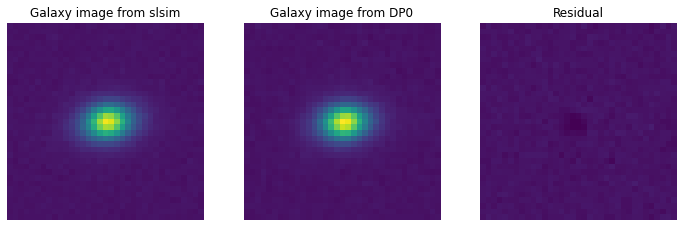

In [24]:
##Disk dominated
# This is a comparision of an image of a galaxy from DP0 at
# (ra, dec)= (61.99284796403353, -36.9900209621661) degree. This comparision is in
# i-band.
global_min = min(
    dc2_galaxy_image_from_slsim_i_1.min(),
    dc2_galaxy_image_from_dp0_i_1.min(),
    diff_i_1.min(),
)
global_max = max(
    dc2_galaxy_image_from_slsim_i_1.max(),
    dc2_galaxy_image_from_dp0_i_1.max(),
    diff_i_1.max(),
)
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(
    dc2_galaxy_image_from_slsim_i_1, origin="lower", vmin=global_min, vmax=global_max
)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(
    dc2_galaxy_image_from_dp0_i_1, origin="lower", vmin=global_min, vmax=global_max
)
plt.title("Galaxy image from DP0")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_i_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

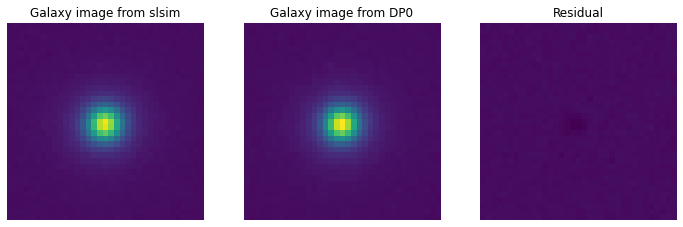

In [25]:
# This is a comparision of an image of a galaxy from DP0 at
# (ra, dec)= (62.00273461841879, -37.00827463174009) degree. This comparision is in
# i-band.
global_min = min(
    dc2_galaxy_image_from_slsim_i_2.min(),
    dc2_galaxy_image_from_dp0_i_2.min(),
    diff_i_2.min(),
)
global_max = max(
    dc2_galaxy_image_from_slsim_i_2.max(),
    dc2_galaxy_image_from_dp0_i_2.max(),
    diff_i_2.max(),
)
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(
    dc2_galaxy_image_from_slsim_i_2, origin="lower", vmin=global_min, vmax=global_max
)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(
    dc2_galaxy_image_from_dp0_i_2, origin="lower", vmin=global_min, vmax=global_max
)
plt.title("Galaxy image from DP0")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_i_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()

## Visualize these images in RGB color

In [26]:
## disk dominated
slsim_image_list_1 = [
    dc2_galaxy_image_from_slsim_i_1,
    dc2_galaxy_image_from_slsim_r_1,
    dc2_galaxy_image_from_slsim_g_1,
]
## Bulge dominated
slsim_image_list_2 = [
    dc2_galaxy_image_from_slsim_i_2,
    dc2_galaxy_image_from_slsim_r_2,
    dc2_galaxy_image_from_slsim_g_2,
]

In [27]:
## disk dominated
slsim_rgb_image_1 = rgb_image_from_image_list(
    image_list=slsim_image_list_1, stretch=0.5
)

## Bulge dominated
slsim_rgb_image_2 = rgb_image_from_image_list(
    image_list=slsim_image_list_2, stretch=0.5
)

In [28]:
## disk dominated
dp0_image_list_1 = [
    dc2_galaxy_image_from_dp0_i_1,
    dc2_galaxy_image_from_dp0_r_1,
    dc2_galaxy_image_from_dp0_g_1,
]

## Bulge dominated
dp0_image_list_2 = [
    dc2_galaxy_image_from_dp0_i_2,
    dc2_galaxy_image_from_dp0_r_2,
    dc2_galaxy_image_from_dp0_g_2,
]

In [29]:
## disk dominated
dp0_rgb_image_1 = rgb_image_from_image_list(image_list=dp0_image_list_1, stretch=0.5)

## Bulge dominated
dp0_rgb_image_2 = rgb_image_from_image_list(image_list=dp0_image_list_2, stretch=0.5)

In [30]:
## disk dominated
diff_list_1 = [diff_i_1, diff_r_1, diff_g_1]
## Bulge dominated
diff_list_2 = [diff_i_2, diff_r_2, diff_g_2]

In [31]:
## disk dominated
rgb_diff_1 = rgb_image_from_image_list(image_list=diff_list_1, stretch=0.5)
## bulge dominated
rgb_diff_2 = rgb_image_from_image_list(image_list=diff_list_2, stretch=0.5)

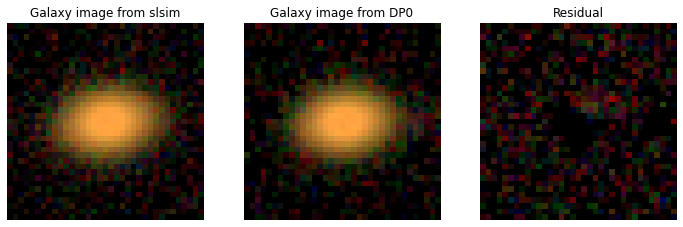

In [32]:
## disk dominated
# This is a comparision of an image of galaxy from DP0 at
# (ra, dec)= (61.99284796403353, -36.9900209621661) degree.
global_min = min(slsim_rgb_image_1.min(), dp0_rgb_image_1.min(), rgb_diff_1.min())
global_max = max(slsim_rgb_image_1.max(), dp0_rgb_image_1.max(), rgb_diff_1.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(slsim_rgb_image_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dp0_rgb_image_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from DP0")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(rgb_diff_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()

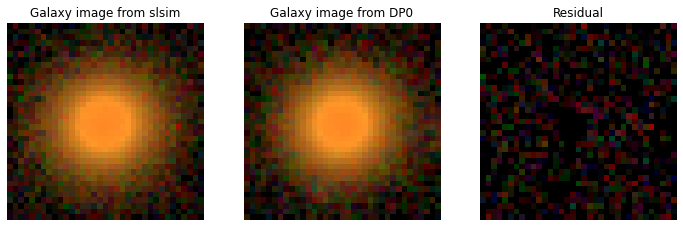

In [33]:
## Bulge dominated
# This is a comparision of an image of galaxy from DP0 at
# (ra, dec)= (62.00273461841879, -37.00827463174009) degree.
global_min = min(slsim_rgb_image_2.min(), dp0_rgb_image_2.min(), rgb_diff_2.min())
global_max = max(slsim_rgb_image_2.max(), dp0_rgb_image_2.max(), rgb_diff_2.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(slsim_rgb_image_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dp0_rgb_image_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from DP0")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(rgb_diff_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()

In [50]:
pixel_slsim_disk=slsim_rgb_image_1.flatten()
pixel_slsim_bulge=slsim_rgb_image_2.flatten()

pixel_dp0_disk=dp0_rgb_image_1.flatten()
pixel_dp0_bulge=dp0_rgb_image_2.flatten()

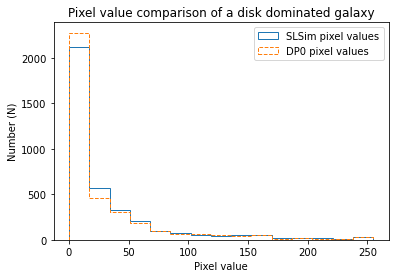

In [66]:
## Comparision of pixel values of a disk dominated galaxy.
plt.title("Pixel value comparison of a disk dominated galaxy")
plt.hist(pixel_slsim_disk, bins=15, histtype="step",
    label="SLSim pixel values")
plt.hist(pixel_dp0_disk, bins=15, ls="--", histtype="step",  label="DP0 pixel values")
plt.xlabel("Pixel value")
plt.ylabel("Number (N)")
plt.legend()

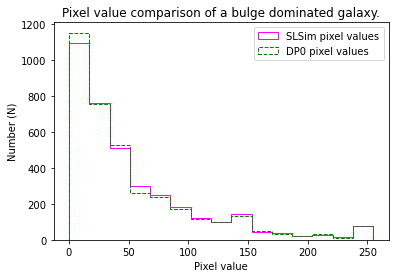

In [67]:
## Comparision of pixel values of bulge dominated galaxy.
plt.title("Pixel value comparison of a bulge dominated galaxy.")
plt.hist(pixel_slsim_bulge, bins=15, histtype="step",
    label="SLSim pixel values", color="magenta")
plt.hist(pixel_dp0_bulge, ls="--", bins=15, histtype="step",  label="DP0 pixel values", 
color="green")
plt.xlabel("Pixel value")
plt.ylabel("Number (N)")
plt.legend()

## Let's simulate an image of a DC2 galaxy using DP0
## cutout for background noise and exposure map for 
## poisson noise.

In above method, we directly used variance map to simulate DP0 background noise. Now,

we simulate an image of the same galaxy with the different approach. Here, we take a

DP0 cutout close to the galaxy image and we use this cutout as a background noise for

our simulation. We take the exposure map of the DP0 galaxy image with specified pixel

size and use this exposure map to generate poisson noise for our simulated image.

Finally, our simulated image have both background noise from DC2 data and poisson noise.

This is the approach we use in lens injection in DP0 field.

In [34]:
## Disk dominated galaxy
## These are DP0 cutouts close to the dp0 galaxy which we want to simulate using slsim.
dc2_galaxy_background_i_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_2_background_i.npy"
)
dc2_galaxy_background_g_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_2_background_g.npy"
)
dc2_galaxy_background_r_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_2_background_r.npy"
)

## These are exposure map of the dp0 galaxy with in (35, 35) pixel size.
dc2_galaxy_exposure_i_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_2_exposure_time_i.npy"
)
dc2_galaxy_exposure_g_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_2_exposure_time_g.npy"
)
dc2_galaxy_exposure_r_1 = np.load(
    "/Users/narayankhadka/downloads/dc2_2_exposure_time_r.npy"
)

In [35]:
## Bulge dominated galaxy
## These are DP0 cutouts close to the dp0 galaxy which we want to simulate using slsim.
dc2_galaxy_background_i_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_background_i.npy"
)
dc2_galaxy_background_g_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_background_g.npy"
)
dc2_galaxy_background_r_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_background_r.npy"
)

## These are exposure map of the dp0 galaxy with in (35, 35) pixel size.
dc2_galaxy_exposure_i_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_exposure_time_i.npy"
)
dc2_galaxy_exposure_g_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_exposure_time_g.npy"
)
dc2_galaxy_exposure_r_2 = np.load(
    "/Users/narayankhadka/downloads/dc2_exposure_time_r.npy"
)

In [36]:
## Here we simulate disk dominated galaxy image using slsim and this includes
# poisson noise.
dc2_galaxy_image_from_slsim_i_21 = lens_image(
    lens_class_i_1,
    band="i",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_i_1,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_i_1,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_g_21 = lens_image(
    lens_class_g_1,
    band="g",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_g_1,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_g_1,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_r_21 = lens_image(
    lens_class_r_1,
    band="r",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_r_1,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_r_1,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)

In [37]:
## Here we simulate bulge dominated galaxy image using slsim and this includes
# poisson noise.
dc2_galaxy_image_from_slsim_i_22 = lens_image(
    lens_class_i_2,
    band="i",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_i_2,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_i_2,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_g_22 = lens_image(
    lens_class_g_2,
    band="g",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_g_2,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_g_2,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)
dc2_galaxy_image_from_slsim_r_22 = lens_image(
    lens_class_r_2,
    band="r",
    mag_zero_point=27,
    num_pix=35,
    psf_kernel=psf_kernel_r_2,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_r_2,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
    angle_rot=0
)

In [38]:
# Let's add dp0 background/cutouts to the simulated disk galaxy image
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_1 = (
    dc2_galaxy_image_from_slsim_i_21 + dc2_galaxy_background_i_1
)
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g_1 = (
    dc2_galaxy_image_from_slsim_g_21 + dc2_galaxy_background_g_1
)
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r_1 = (
    dc2_galaxy_image_from_slsim_r_21 + dc2_galaxy_background_r_1
)

In [39]:
# Let's add dp0 background/cutouts to the simulated bulge galaxy image
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_2 = (
    dc2_galaxy_image_from_slsim_i_22 + dc2_galaxy_background_i_2
)
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g_2 = (
    dc2_galaxy_image_from_slsim_g_22 + dc2_galaxy_background_g_2
)
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r_2 = (
    dc2_galaxy_image_from_slsim_r_22 + dc2_galaxy_background_r_2
)

In [40]:
##disk dominated
## compute the difference between dp0 image and slsim image in each band
diff_i_n_1 = (
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_1
    - dc2_galaxy_image_from_dp0_i_1
)
diff_r_n_1 = (
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r_1
    - dc2_galaxy_image_from_dp0_r_1
)
diff_g_n_1 = (
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g_1
    - dc2_galaxy_image_from_dp0_g_1
)

In [41]:
##bulge dominated
## compute the difference between dp0 image and slsim image in each band
diff_i_n_2 = (
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_2
    - dc2_galaxy_image_from_dp0_i_2
)
diff_r_n_2 = (
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r_2
    - dc2_galaxy_image_from_dp0_r_2
)
diff_g_n_2 = (
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g_2
    - dc2_galaxy_image_from_dp0_g_2
)

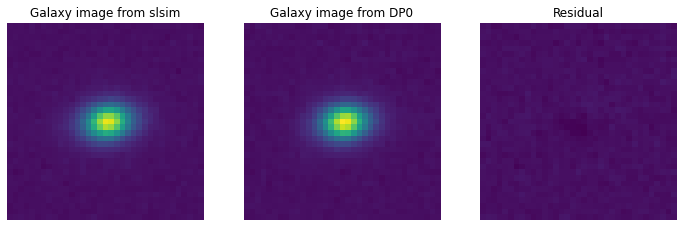

In [42]:
# disk dominated
# This is a comparision of an image of galaxy from DP0 at
# (ra, dec)= (61.99284796403353, -36.9900209621661) degree.
global_min = min(
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_1.min(),
    dc2_galaxy_image_from_dp0_i_1.min(),
    diff_i_n_1.min(),
)
global_max = max(
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_1.max(),
    dc2_galaxy_image_from_dp0_i_1.max(),
    diff_i_n_1.max(),
)
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_1,
    origin="lower",
    vmin=global_min,
    vmax=global_max,
)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(
    dc2_galaxy_image_from_dp0_i_1, origin="lower", vmin=global_min, vmax=global_max
)
plt.title("Galaxy image from DP0")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_i_n_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()

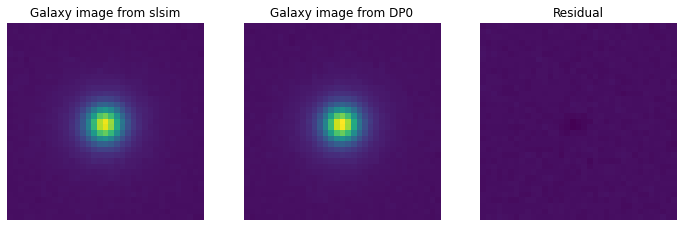

In [43]:
# Bulge dominated
# This is a comparision of an image of galaxy from DP0 at
# (ra, dec)= (62.00273461841879, -37.00827463174009) degree.
global_min = min(
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_2.min(),
    dc2_galaxy_image_from_dp0_i_2.min(),
    diff_i_n_2.min(),
)
global_max = max(
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_2.max(),
    dc2_galaxy_image_from_dp0_i_2.max(),
    diff_i_n_2.max(),
)
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_2,
    origin="lower",
    vmin=global_min,
    vmax=global_max,
)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(
    dc2_galaxy_image_from_dp0_i_2, origin="lower", vmin=global_min, vmax=global_max
)
plt.title("Galaxy image from DP0")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff_i_n_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()

In [44]:
## Disk dominated
## Produce RGB color image for slsim
slsim_image_list_n_1 = [
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_1,
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r_1,
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g_1,
]

slsim_rgb_image_n_1 = rgb_image_from_image_list(
    image_list=slsim_image_list_n_1, stretch=0.5
)

In [45]:
## Bulge dominated
## Produce RGB color image for slsim
slsim_image_list_n_2 = [
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i_2,
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r_2,
    dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g_2,
]

slsim_rgb_image_n_2 = rgb_image_from_image_list(
    image_list=slsim_image_list_n_2, stretch=0.5
)

In [46]:
## Disk dominated
diff_n_list_1 = [diff_i_n_1, diff_r_n_1, diff_g_n_1]

## Bulge dominated
diff_n_list_2 = [diff_i_n_2, diff_r_n_2, diff_g_n_2]

In [47]:
## Disk dominated
rgb_diff_nn_1 = rgb_image_from_image_list(image_list=diff_n_list_1, stretch=0.5)

## bulge dominated
rgb_diff_nn_2 = rgb_image_from_image_list(image_list=diff_n_list_2, stretch=0.5)

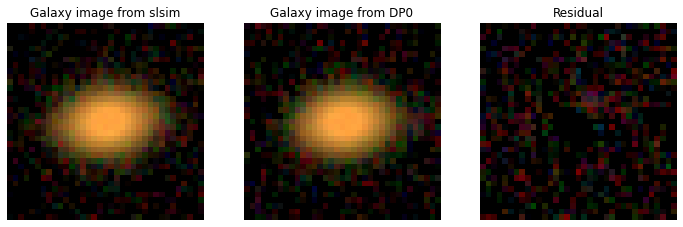

In [48]:
# This is a comparision of an image of galaxy from DP0 at
# (ra, dec)= (61.99284796403353, -36.9900209621661) degree.
global_min = min(slsim_rgb_image_n_1.min(), dp0_rgb_image_1.min(), rgb_diff_nn_1.min())
global_max = max(slsim_rgb_image_n_1.max(), dp0_rgb_image_1.max(), rgb_diff_nn_1.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(slsim_rgb_image_n_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dp0_rgb_image_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from DP0")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(rgb_diff_nn_1, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()

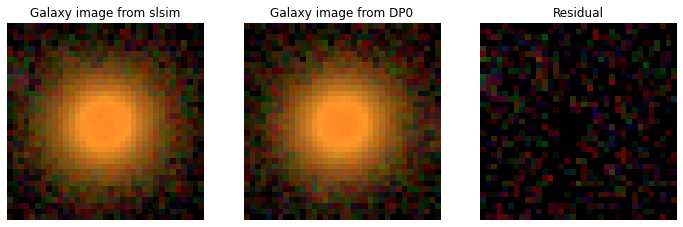

In [49]:
# This is a comparision of an image of galaxy from DP0 at
# (ra, dec)= (62.00273461841879, -37.00827463174009) degree.
global_min = min(slsim_rgb_image_n_2.min(), dp0_rgb_image_2.min(), rgb_diff_nn_2.min())
global_max = max(slsim_rgb_image_n_2.max(), dp0_rgb_image_2.max(), rgb_diff_nn_2.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(slsim_rgb_image_n_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from slsim")
plt.axis("off")  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dp0_rgb_image_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Galaxy image from DP0")
plt.axis("off")


plt.subplot(1, 3, 3)
plt.imshow(rgb_diff_nn_2, origin="lower", vmin=global_min, vmax=global_max)
plt.title("Residual")
plt.axis("off")

plt.show()